In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

In [2]:
def bls(t, x, qmi, qma, fmin, df, nf, nb):
    """Frist trial, BLS algorithm, only minor modification from author's code"""
    
    n = len(t); rn = len(x)
    #! use try
    if n != rn:
        print "Different size of array, t and x"
        return 0

    rn = float(rn) # float of n

    minbin = 5
    nbmax = 2000
    if nb > nbmax:
        print "Error: NB > NBMAX!"
        return 0

    tot = t[-1] - t[0] # total time span

    if fmin < 1.0/tot:
        print "Error: fmin < 1/T"
        return 0

    # parameters in binning (after folding)
    kmi = int(qmi*nb) # nb is number of bin -> a single period
    if kmi < 1: 
        kmi = 1
    kma = int(qma*nb) + 1
    kkmi = rn*qmi # to check the bin size
    if kkmi < minbin: 
        kkmi = minbin

    # For the extension of arrays (edge effect: transit happen at the edge of data set)
    nb1 = nb + 1
    nbkma = nb + kma
        
    # Data centering
    t1 = t[0]
    u = t - t1
    s = np.mean(x) # ! Modified
    v = x - s

    bpow = 0.0
    p = np.zeros(nf)
    # Start period search
    for jf in range(nf):
        f0 = fmin + df*jf # iteration in frequency not period
        p0 = 1.0/f0

        # Compute folded time series with p0 period
        ibi = np.zeros(nbkma)
        y = np.zeros(nbkma)
        for i in range(n):
            ph = u[i]*f0 # instead of t mod P, he use t*f then calculate the phase (less computation)
            ph = ph - int(ph)
            j = int(nb*ph) # data to a bin 
            ibi[j] = ibi[j] + 1 # number of data in a bin
            y[j] = y[j] + v[i] # sum of light in a bin
        
        # Extend the arrays  ibi()  and  y() beyond nb by wrapping
        for j in range(nb1, nbkma):
            jnb = j - nb
            ibi[j] = ibi[jnb]
            y[j] = y[jnb]

        # Compute BLS statictics for this trial period
        power = 0.0

        for i in range(nb): # shift the test period
            s = 0.0
            k = 0
            kk = 0
            nb2 = i + kma
            # change the size of test period (from kmi to kma)
            for j in range(i, nb2): 
                k = k + 1
                kk = kk + ibi[j]
                s = s + y[j]
                if k < kmi: continue # only calculate SR for test period > kmi
                if kk < kkmi: continue # 
                rn1 = float(kk)
                powo = s*s/(rn1*(rn - rn1))
                if powo > power: # save maximum SR in a test period
                    power = powo # SR value
                    jn1 = i # 
                    jn2 = j
                    rn3 = rn1
                    s3 = s

        power = math.sqrt(power)
        p[jf] = power

        if power > bpow:
            bpow = power # Save the absolute maximum of SR
            in1 = jn1
            in2 = jn2
            qtran = rn3/rn
            # depth = -s3*rn/(rn3*(rn - rn3))
            # ! Modified
            high = -s3/(rn - rn3)
            low = s3/rn3
            depth = high - low
            bper = p0
    
    # ! add
    sde = (bpow - np.mean(p))/np.std(p) # signal detection efficiency

    return bpow, in1, in2, qtran, depth, bper, sde, p, high, low

# False positive detection test

### We generate data without transit event and check with BLS detection algorithm.

### Test 01

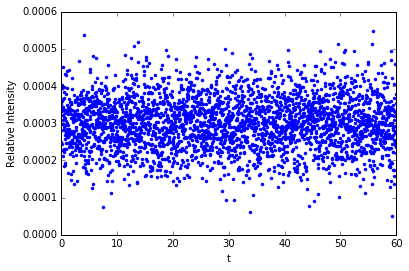

In [3]:
t = np.linspace(0.0, 60.0, 3000)
f = np.zeros(3000) + 0.0003 
rs = np.random.RandomState(seed=13)
errors = 0.00007*np.ones_like(f)
f += errors*rs.randn(len(t))

plt.plot(t, f, 'b.')
plt.xlabel("t")
plt.ylabel("Relative Intensity")

In [4]:
qmi = 0.01
qma = 0.1
fmin = 0.125 
df = 0.001 
nf = 1000
nb = 300
res = bls(t, f, qmi, qma, fmin, df, nf, nb)
print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6]

Best SR:  6.73426915217e-06 
Ingress:  285 
Egress:  291 
q:  0.0233333333333 
Depth:  -4.46096580905e-05 
Period:  1.03626943005 
SDE:  4.6644467946


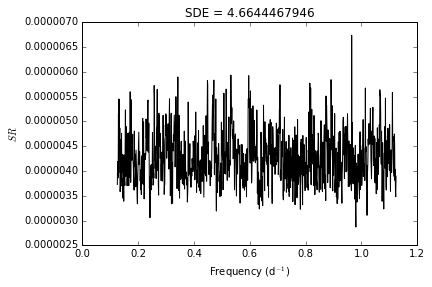

In [5]:
freq = np.arange(0.125, 1.125, 0.001)
plt.plot(freq, res[7], 'k')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")

high =  -1.04089202211e-06 
low =  4.35687660684e-05


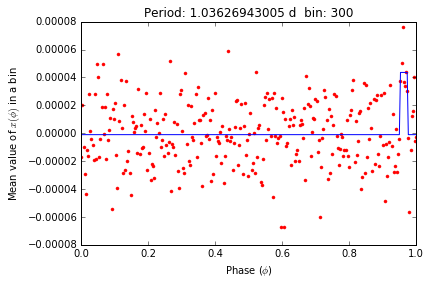

In [6]:
t1 = t[0]
u = t - t1
s = np.mean(f)
v = f - s

f0 = 1.0/res[5] #  freq = 1/T
nbin = nb # number of bin
n = len(t)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
phase = np.linspace(0.0, 1.0, nbin)

for i in range(n):
    ph = u[i]*f0 
    ph = ph - int(ph)
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in a bin
    y[j] = y[j] + v[i] # sum of light in a bin


plt.plot(phase, y/ibi, 'r.')
fite = np.zeros(nbin) + res[8] # H
fite[res[1]:res[2]+1] = res[9] # L
    
plt.plot(phase, fite)
plt.title("Period: {0} d  bin: {1}".format(1/f0, nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

print 'high = ', res[8], '\nlow = ', res[9]

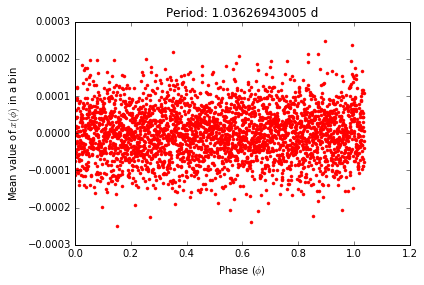

In [7]:
T0 = res[5]
n = len(t)
y = np.zeros(n)
y = t % T0

plt.plot(y, v, 'r.')
plt.title("Period: {0} d".format(1/f0))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

### Test 02

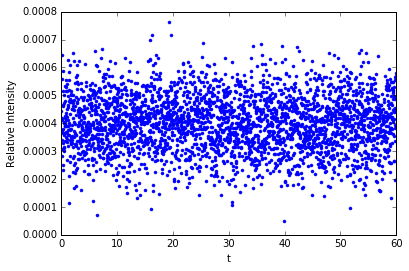

In [8]:
t = np.linspace(0.0, 60.0, 3000)
f = np.zeros(3000) + 0.0004
rs = np.random.RandomState(seed=5)
errors = 0.0001*np.ones_like(f)
f += errors*rs.randn(len(t))

plt.plot(t, f, 'b.')
plt.xlabel("t")
plt.ylabel("Relative Intensity")

In [9]:
qmi = 0.01
qma = 0.1
fmin = 0.125 
df = 0.001 
nf = 1000
nb = 300
res = bls(t, f, qmi, qma, fmin, df, nf, nb)
print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6]

Best SR:  9.8358823806e-06 
Ingress:  114 
Egress:  132 
q:  0.0633333333333 
Depth:  4.03835618246e-05 
Period:  1.0460251046 
SDE:  4.54254820176


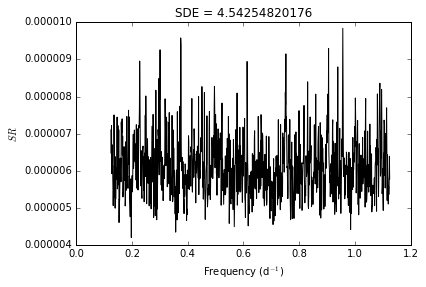

In [10]:
freq = np.arange(0.125, 1.125, 0.001)
plt.plot(freq, res[7], 'k')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")

high =  2.55762558222e-06 
low =  -3.78259362424e-05


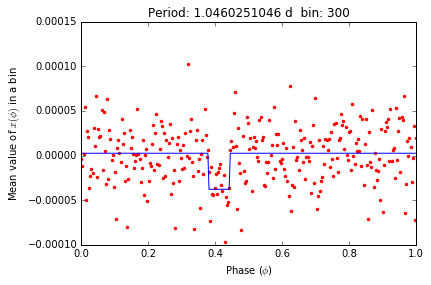

In [11]:
t1 = t[0]
u = t - t1
s = np.mean(f)
v = f - s

f0 = 1.0/res[5] #  freq = 1/T
nbin = nb # number of bin
n = len(t)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
phase = np.linspace(0.0, 1.0, nbin)

for i in range(n):
    ph = u[i]*f0 
    ph = ph - int(ph)
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in a bin
    y[j] = y[j] + v[i] # sum of light in a bin


plt.plot(phase, y/ibi, 'r.')
fite = np.zeros(nbin) + res[8] # H
fite[res[1]:res[2]+1] = res[9] # L
    
plt.plot(phase, fite)
plt.title("Period: {0} d  bin: {1}".format(1/f0, nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

print 'high = ', res[8], '\nlow = ', res[9]

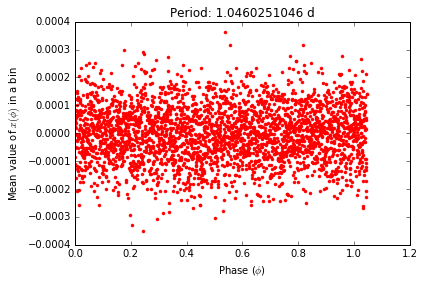

In [12]:
T0 = res[5]
n = len(t)
y = np.zeros(n)
y = t % T0

plt.plot(y, v, 'r.')
plt.title("Period: {0} d".format(1/f0))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

### Test 03

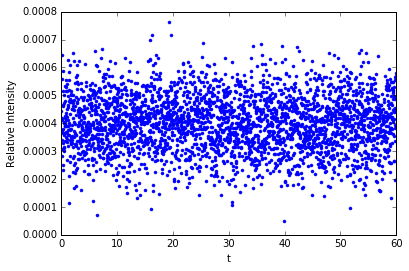

In [13]:
t = np.linspace(0.0, 60.0, 3000)
f = np.zeros(3000) + 0.0004
rs = np.random.RandomState(seed=5)
errors = 0.0001*np.ones_like(f)
f += errors*rs.randn(len(t))

plt.plot(t, f, 'b.')
plt.xlabel("t")
plt.ylabel("Relative Intensity")

In [14]:
qmi = 0.01
qma = 0.1
fmin = 0.02
df = 0.0001 
nf = 1000
nb = 300
res = bls(t, f, qmi, qma, fmin, df, nf, nb)
print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6]

Best SR:  8.3509634266e-06 
Ingress:  160 
Egress:  164 
q:  0.0166666666667 
Depth:  6.5232170049e-05 
Period:  11.9760479042 
SDE:  2.93578229574


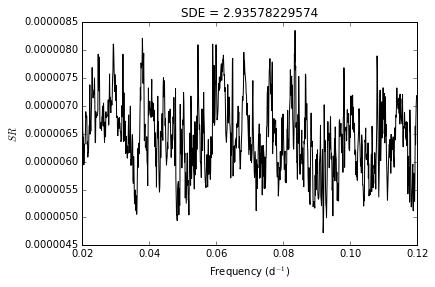

In [15]:
freq = np.arange(0.02, 0.12, 0.0001)
plt.plot(freq, res[7], 'k')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")

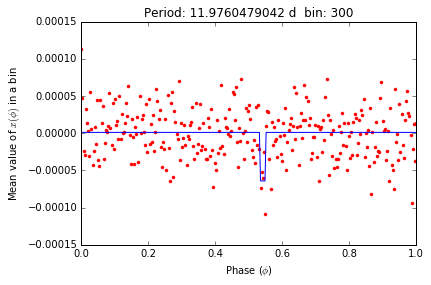

In [16]:
t1 = t[0]
u = t - t1
s = np.mean(f)
v = f - s

f0 = 1.0/res[5] #  freq = 1/T
nbin = nb # number of bin
n = len(t)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
phase = np.linspace(0.0, 1.0, nbin)

for i in range(n):
    ph = u[i]*f0 
    ph = ph - int(ph)
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in a bin
    y[j] = y[j] + v[i] # sum of light in a bin


plt.plot(phase, y/ibi, 'r.')
fite = np.zeros(nbin) + res[8] # H
fite[res[1]:res[2]+1] = res[9] # L
    
plt.plot(phase, fite)
plt.title("Period: {0} d  bin: {1}".format(1/f0, nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

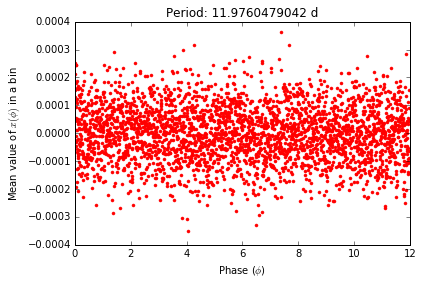

In [17]:
T0 = res[5]
n = len(t)
y = np.zeros(n)
y = t % T0

plt.plot(y, v, 'r.')
plt.title("Period: {0} d".format(1/f0))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")